# John Schueler
# NLP Program 4 
# Please use Google Colab, set runtime to 'GPU' or 'TPU' and High-RAM setting
#Link to blogtext.csv (800 MB) on Kaggle [link text](https://www.kaggle.com/datasets/dsrivastava2020/blogtextcsv)

**topics covered**:
cosine similarity, document term/feature matrix, bag of words (BOW), restring, heat map, tf-idf vectors, word2vec (w2v), tokenization, punctuation/stopword cleaning and more

In [ ]:
# import packages

import pandas as pd

import pandas as pd
import string
import nltk
from nltk import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
%matplotlib inline
import gensim
from gensim.corpora import Dictionary
import gensim.models.keyedvectors as word2vec
from gensim.similarities import SparseMatrixSimilarity

import heapq
import scipy
from scipy import sparse

import pandas as pd
import email
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import string
import spacy
import collections
from collections import Counter
from itertools import chain

# New ones
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# loading in the dataset
blogs = pd.read_csv('blogtext.csv')

In [ ]:
# viewing a subset of the data
blogs.head(5)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
# cutting down the sample size to 30 blogs
blogs = blogs.sample(n = 30, random_state = 500)

In [ ]:
# reset index
blogs.reset_index(drop=True, inplace=True)
blogs

,id,gender,age,topic,sign,date,text
0,3351411,male,26,indUnk,Gemini,"26,May,2004",I'll post the link since I though...
1,3115623,male,23,Accounting,Virgo,"24,June,2004",I'm pretty frightened of Natalie ri...
2,1266843,female,24,Communications-Media,Pisces,"20,February,2004","What the hell, ok so it's freezing in m..."
3,1239610,male,17,indUnk,Scorpio,"25,November,2003",Celtic game was an anti climax. Excitin...
4,3650974,male,23,Student,Scorpio,"10,August,2004",...if I implied in my previous po...
5,3946990,male,23,Student,Leo,"16,July,2004",urlLink http://electronics.howstuffwor...
6,49663,male,33,indUnk,Taurus,"01,August,2001",My friend Belisha has the right ide...
7,2543400,male,17,Student,Capricorn,"01,June,2004","urlLink Another pic, but there'..."
8,4246642,male,15,Student,Aries,"16,August,2004","I just thought i'd show you guys, b..."
9,751740,male,26,Communications-Media,Capricorn,"18,August,2003",There were problems with the temp...


In [ ]:
# tokenize words
re_tokenizer = RegexpTokenizer("[\\w']+")
blogs['body_cleaned'] = blogs['text'].apply(re_tokenizer.tokenize)

In [ ]:
# Clean up 
punc = string.punctuation 
stopwords_nltk = nltk.corpus.stopwords.words('english')
# stopwords_nltk.extend(['ect', 'hou', 'com', 'subject', 'http', 'said', 'please', 'pm', 'cc', 'www']) # Custom stop words

blogs['body_cleaned'] = blogs['body_cleaned'].apply(lambda x: [word.lower() for word in x])
blogs['body_cleaned'] = blogs['body_cleaned'].apply(lambda x: [word for word in x if word not in punc])
blogs['body_cleaned'] = blogs['body_cleaned'].apply(lambda x: [word for word in x if word not in stopwords_nltk])
blogs['body_cleaned'] = blogs['body_cleaned'].apply(lambda x: [word for word in x if len(word)>1]) 

In [ ]:
# re string 'body_cleaned_string'
blogs['body_cleaned_string'] = blogs['body_cleaned'].apply(lambda x: " ".join(x))

In [ ]:
# view altered data frame
blogs.head(5)

,id,gender,age,topic,sign,date,text,body_cleaned,body_cleaned_string
0,3351411,male,26,indUnk,Gemini,"26,May,2004",I'll post the link since I though...,"[i'll, post, link, since, thought, interesting...",i'll post link since thought interesting never...
1,3115623,male,23,Accounting,Virgo,"24,June,2004",I'm pretty frightened of Natalie ri...,"[i'm, pretty, frightened, natalie, right, look...",i'm pretty frightened natalie right looked rea...
2,1266843,female,24,Communications-Media,Pisces,"20,February,2004","What the hell, ok so it's freezing in m...","[hell, ok, freezing, house, know, complain, he...",hell ok freezing house know complain heat sill...
3,1239610,male,17,indUnk,Scorpio,"25,November,2003",Celtic game was an anti climax. Excitin...,"[celtic, game, anti, climax, exciting, neverth...",celtic game anti climax exciting nevertheless ...
4,3650974,male,23,Student,Scorpio,"10,August,2004",...if I implied in my previous po...,"[implied, previous, post, myst, iv, pretty, ni...",implied previous post myst iv pretty nifty abs...


In [ ]:
# Create the document term/feature matrix
cv_vec = CountVectorizer()
bow = cv_vec.fit_transform(blogs['body_cleaned_string'])

In [ ]:
# Compute cosine similarity between each blog's bag-of-words vector and the 5th blog
bow_cosine_sim = cosine_similarity(bow[5:6], bow)
bow_cosine_sim

# Produces the cosine sim scores for each blog compared to the 5th blog

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.05050763, 0.20412415, 0.        , 0.        ,
        0.11785113, 0.10660036, 0.08737041, 0.125     , 0.07715167,
        0.        , 0.        , 0.        , 0.00987056, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.125     ,
        0.25      , 0.        , 0.04705919, 0.        , 0.        ]])

In [ ]:
# Look at it in a dataframe
bow_df = pd.DataFrame(bow_cosine_sim)
bow_df = bow_df.transpose()
bow_df = bow_df.sort_values(by=[0], ascending = False)
bow_df

,0
5,1.000000
25,0.250000
7,0.204124
24,0.125000
13,0.125000
10,0.117851
11,0.106600
12,0.087370
14,0.077152
6,0.050508


In [ ]:
# Create doc_id column from index
bow_df['doc_id'] = bow_df.index 
bow_df.columns = ['cosine_sim_fifth_row', 'doc_id']
bow_df

,cosine_sim_fifth_row,doc_id
5,1.000000,5
25,0.250000,25
7,0.204124,7
24,0.125000,24
13,0.125000,13
10,0.117851,10
11,0.106600,11
12,0.087370,12
14,0.077152,14
6,0.050508,6


In [ ]:
# comparing all articles pair-wise
bow_pairs = cosine_similarity(bow, dense_output=False)
print(bow_pairs)

  (0, 8)	0.07273929674533079
  (0, 9)	0.17213259316477408
  (0, 24)	0.034020690871988585
  (0, 22)	0.03829899930809508
  (0, 14)	0.04199605255658081
  (0, 11)	0.05802588531856595
  (0, 3)	0.048112522432468816
  (0, 1)	0.04667600280093366
  (0, 17)	0.0417482860723433
  (0, 28)	0.0888231183368655
  (0, 20)	0.08535791995526398
  (0, 16)	0.09200874124564723
  (0, 4)	0.042766686606638946
  (0, 27)	0.093924511922736
  (0, 23)	0.04063983088663639
  (0, 21)	0.07836361325123112
  (0, 15)	0.038880789567986955
  (0, 2)	0.08606629658238704
  (0, 26)	0.1440402702417041
  (0, 18)	0.0967113164099523
  (0, 12)	0.05944803125053514
  (0, 29)	0.042365275518360224
  (0, 0)	1.0000000000000007
  (1, 3)	0.06063390625908324
  (1, 22)	0.04826639337239525
  :	:
  (29, 1)	0.05695032150021047
  (29, 10)	0.014675761934890761
  (29, 14)	0.06084776233371341
  (29, 11)	0.03982417842322868
  (29, 3)	0.03668940483722691
  (29, 24)	0.04929232122039316
  (29, 20)	0.06075235818252548
  (29, 0)	0.042365275518360224
  (29, 

In [ ]:
# matrix format
bow_pairs_df = pd.DataFrame(bow_pairs.toarray())
bow_pairs_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.046676,0.086066,0.048113,0.042767,0.000000,0.000000,0.000000,0.072739,0.172133,0.000000,0.058026,0.059448,0.000000,0.041996,0.038881,0.092009,0.041748,0.096711,0.000000,0.085358,0.078364,0.038299,0.040640,0.034021,0.000000,0.144040,0.093925,0.088823,0.042365
1,0.046676,1.000000,0.108465,0.060634,0.026948,0.000000,0.069296,0.000000,0.000000,0.000000,0.000000,0.000000,0.044952,0.085749,0.000000,0.000000,0.115954,0.000000,0.094796,0.000000,0.107572,0.135792,0.048266,0.069142,0.000000,0.000000,0.123768,0.075325,0.055970,0.056950
2,0.086066,0.108465,1.000000,0.055902,0.000000,0.000000,0.079860,0.000000,0.042258,0.000000,0.000000,0.067420,0.075980,0.039528,0.073193,0.112938,0.120268,0.133395,0.087398,0.018380,0.066118,0.102432,0.066749,0.043678,0.079057,0.000000,0.102698,0.119051,0.060202,0.045942
3,0.048113,0.060634,0.055902,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075378,0.015445,0.000000,0.054554,0.000000,0.059761,0.000000,0.097714,0.000000,0.018481,0.101797,0.024876,0.047513,0.044194,0.000000,0.025516,0.022184,0.096154,0.036689
4,0.042767,0.026948,0.000000,0.000000,1.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.067003,0.082374,0.000000,0.024246,0.067344,0.053121,0.024103,0.077550,0.091333,0.065709,0.073520,0.055280,0.063351,0.078567,0.000000,0.090722,0.078876,0.094017,0.048919
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.050508,0.204124,0.000000,0.000000,0.117851,0.106600,0.087370,0.125000,0.077152,0.000000,0.000000,0.000000,0.009871,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.250000,0.000000,0.047059,0.000000,0.000000
6,0.000000,0.069296,0.079860,0.000000,0.015873,0.050508,1.000000,0.082479,0.000000,0.000000,0.047619,0.043073,0.044129,0.050508,0.031174,0.000000,0.068299,0.000000,0.071790,0.023486,0.010560,0.116340,0.042644,0.024134,0.025254,0.101015,0.077762,0.031691,0.000000,0.041931
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.204124,0.082479,1.000000,0.000000,0.000000,0.192450,0.174078,0.000000,0.204124,0.125988,0.000000,0.000000,0.000000,0.024178,0.000000,0.000000,0.000000,0.000000,0.039624,0.000000,0.408248,0.009821,0.076847,0.000000,0.271138
8,0.072739,0.000000,0.042258,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.046701,0.000000,0.000000,0.076360,0.045175,0.000000,0.000000,0.062137,0.027940,0.000000,0.000000,0.063852,0.000000,0.000000,0.077152,0.016769,0.000000,0.011094
9,0.172133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012485,0.000000,0.000000,0.000000,0.000000,0.009444,0.000000,0.000000,0.030429,0.000000,0.000000,0.013126


<AxesSubplot:>

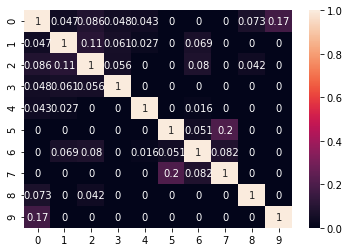

In [ ]:
# heatmap of cosine similarity scores of blogs vectorized with the b.o.w. technique. Similarity is compared to the 5th blog.
# Subset your dataframe to experiment
subset = bow_pairs_df.iloc[:10]  
subset = subset.iloc[:, 0:10] 
sns.heatmap(subset, annot=True)

In [ ]:
# b.o.w. in pairs ranked by similarity
bow_pairs_coo = bow_pairs.tocoo() 
article_1 = pd.DataFrame(bow_pairs_coo.row) 
article_2 = pd.DataFrame(bow_pairs_coo.col)
cosine_sim = pd.DataFrame(bow_pairs_coo.data)

bow_pairs_df2 = pd.concat([article_1, article_2, cosine_sim], axis = 1)
bow_pairs_df2.columns = ('blog_1', 'blog_2', 'cosine_sim') 
bow_pairs_df2 = bow_pairs_df2.sort_values(by=['cosine_sim'], ascending = False)
bow_pairs_df2.head(40)

,blog_1,blog_2,cosine_sim
538,26,26,1.000000
103,4,4,1.000000
429,21,21,1.000000
22,0,0,1.000000
294,15,15,1.000000
138,6,6,1.000000
589,28,28,1.000000
406,20,20,1.000000
453,22,22,1.000000
276,14,14,1.000000


In [ ]:
# duplicate pairs dropped for b.o.w.
bow_pairs_df2 = bow_pairs_df2.drop(bow_pairs_df2[bow_pairs_df2['blog_1'] == bow_pairs_df2['blog_2']].index)
bow_pairs_df2 = bow_pairs_df2.reset_index(drop = True) # Reset index
bow_pairs_df2 = bow_pairs_df2.sort_values(by=['cosine_sim'], ascending = False) # Sort
bow_pairs_df2

,blog_1,blog_2,cosine_sim
0,25,7,0.408248
1,7,25,0.408248
2,16,21,0.340679
3,21,16,0.340679
4,7,29,0.271138
...,...,...,...
583,23,9,0.009444
584,18,10,0.009306
585,10,18,0.009306
586,23,10,0.003520


In [ ]:
# eliminate duplicate pairs to reduce redundancy
bow_pairs_df2 = bow_pairs_df2.iloc[::2, :]
bow_pairs_df2 = bow_pairs_df2.reset_index(drop = True) # Reset index
bow_pairs_df2

,blog_1,blog_2,cosine_sim
0,25,7,0.408248
1,16,21,0.340679
2,7,29,0.271138
3,13,25,0.250000
4,25,13,0.250000
...,...,...,...
289,18,5,0.009871
290,7,26,0.009821
291,9,23,0.009444
292,18,10,0.009306


In [ ]:
# Create tf-idf vectors
tfidf_vec = TfidfVectorizer() 
tfidf = tfidf_vec.fit_transform(blogs['body_cleaned_string'])

In [ ]:
# Compare all blogs pairwise
tfidf_pairs = cosine_similarity(tfidf, dense_output=False)
print(tfidf_pairs)

  (0, 8)	0.0425441972004959
  (0, 4)	0.02975176942561527
  (0, 24)	0.009880470237455
  (0, 16)	0.042675062556513335
  (0, 14)	0.011647658441130776
  (0, 12)	0.030692043484221
  (0, 11)	0.01650573860804766
  (0, 3)	0.012973858513409061
  (0, 22)	0.016828090655744775
  (0, 9)	0.13232496495659363
  (0, 17)	0.04023316472569754
  (0, 1)	0.05754609792922635
  (0, 29)	0.0270933586170505
  (0, 28)	0.03904537418734329
  (0, 26)	0.10150444835546456
  (0, 20)	0.04668336940936454
  (0, 27)	0.058045808607661634
  (0, 23)	0.023584732298546525
  (0, 21)	0.039280687842827997
  (0, 18)	0.06626345470393386
  (0, 15)	0.02005528022632179
  (0, 2)	0.038152020675558
  (0, 0)	1.0000000000000002
  (1, 0)	0.05754609792922635
  (1, 4)	0.022251010887986568
  :	:
  (29, 1)	0.03130637819623562
  (29, 2)	0.027610211389403623
  (29, 3)	0.01822495710516644
  (29, 11)	0.01052788987313728
  (29, 4)	0.028145948167594338
  (29, 6)	0.026242128839612314
  (29, 7)	0.2976776104366669
  (29, 9)	0.01049041680334503
  (29, 10)	

In [ ]:
# TF-IDF
# Viewed by pairs ranked by similarity. 
tfidf_pairs_coo = tfidf_pairs.tocoo()  
blog_1 = pd.DataFrame(tfidf_pairs_coo.row) 
blog_2 = pd.DataFrame(tfidf_pairs_coo.col) 
cosine_sim = pd.DataFrame(tfidf_pairs_coo.data) 

tfidf_pairs_df2 = pd.concat([blog_1, blog_2, cosine_sim], axis = 1) 
tfidf_pairs_df2.columns = ('blog_1', 'blog_2', 'cosine_sim') 
tfidf_pairs_df2 = tfidf_pairs_df2.sort_values(by=['cosine_sim'], ascending = False) 

# all self matches are dropped to reduce redundancy
tfidf_pairs_df2 = tfidf_pairs_df2.drop(tfidf_pairs_df2[tfidf_pairs_df2['blog_1'] == tfidf_pairs_df2['blog_2']].index)
tfidf_pairs_df2 = tfidf_pairs_df2.reset_index(drop = True) 
tfidf_pairs_df2 = tfidf_pairs_df2.sort_values(by=['cosine_sim'], ascending = False) 

# duplicate pairs eliminated to reduce redundancy
tfidf_pairs_df2 = tfidf_pairs_df2.iloc[::2, :]
tfidf_pairs_df2 = tfidf_pairs_df2.reset_index(drop = True) # Reset index
tfidf_pairs_df2



,blog_1,blog_2,cosine_sim
0,7,29,0.297678
1,21,16,0.227834
2,25,7,0.199515
3,21,26,0.163213
4,26,18,0.149652
...,...,...,...
289,20,11,0.005998
290,11,23,0.004623
291,20,14,0.004233
292,12,3,0.003867


In [ ]:
print(type(tfidf_pairs_df2))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# allow for max columns to be displayed for dataframes in pandas
pd.set_option('display.max_columns', None)


In [ ]:
# view tfidf dataframe blog pairs where the 1st blog is blog 0
df_z = tfidf_pairs_df2.loc[(tfidf_pairs_df2['blog_1'] == 0)]

In [ ]:
# viewing tfidf cosine similarity documents that are to be contrasted with b.o.w. and word2vec documents.
print(df_z)

     blog_1  blog_2  cosine_sim
6         0       9    0.132325
79        0      27    0.058046
127       0      16    0.042675
128       0       8    0.042544
143       0       2    0.038152
172       0      12    0.030692
180       0       4    0.029752
192       0      29    0.027093
242       0      11    0.016506
271       0      24    0.009880


In [ ]:
df_z2 = tfidf_pairs_df2.loc[(tfidf_pairs_df2['blog_2'] == 25)]

In [ ]:
# I created a seperate word document and copy pasted all of the scores from all 3
# vectorization techniques that corresponded to each document pair for analysis.
# 
print(df_z2)

    blog_1  blog_2  cosine_sim
14      13      25    0.112736
16       5      25    0.110764
22      10      25    0.105897
27      11      25    0.099894
56      14      25    0.070492


In [ ]:
# I prefer to use the bag of words method for vectorizing words. Most of the similarity scores for the documents
# that were compared pair-wise had very similar, if not the same, scores across the bag of words and word2vector methods. 
# The tfidf consine similarity scores were consistently almost exactly 1/2 of what the scores for the other 2 methods were.
# One of the only inconsistencies I found between word2vec and the bag of words cosine simalrity scores was
# was between documents 2 and 1. Word2vec was ranked 7 points 
# higher in it's similarity score. Word2Vec scored .174891 and b.o.w. scored .108465
# The tdfidf dataframe was not able to return me documents 2,1 or 1,2 and thus was unable to compare the tfidf score for
# this particular set of documents. Considering that tfidf cosine scores are not consistently the same as the other 2 vectors are,
# this didn't cause too much doubt in my decision-making process between which vectorization technique I prefer. 
# I read other blog-pairs that had cosine similarity scores close to 10% and others
# that were closer to 17.4%. Although the difference was not drastic, I thought that the blogs in contention, 2 and 1, were
# less similar than word2vec gave it credit for in contrast to other blogs that were similarly scored. For this reason,
# I determined that I prefered the Bag of Words word vectorization method over the other 2 methods. 
 

In [ ]:
# Load in the pretrained word2vec vectors 


word_vectors = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [ ]:
# using tokenized version of text
dictionary = Dictionary(blogs['body_cleaned']) 
corpus = [dictionary.doc2bow(document) for document in blogs['body_cleaned']]

In [ ]:
index = SparseMatrixSimilarity(corpus, num_features=len(dictionary))

In [ ]:
# drop second, output 1st. don't want repeat pairs of the blogs. best to eliminate redundancy.
w2v_pairs = []

for i in index:
    top = heapq.nlargest(2, enumerate(i), key=lambda x: x[1])
    w2v_pairs.append(top)

w2v_pairs_df = pd.DataFrame(w2v_pairs)   
w2v_pairs_df

,0,1
0,"(0, 0.99999976)","(9, 0.1721326)"
1,"(1, 1.0000002)","(2, 0.17489073)"
2,"(2, 0.9999998)","(1, 0.17489073)"
3,"(3, 1.0)","(21, 0.10179733)"
4,"(4, 0.9999995)","(28, 0.09316683)"
5,"(5, 0.99999994)","(25, 0.24999999)"
6,"(6, 0.99999976)","(21, 0.1163398)"
7,"(7, 0.9999998)","(25, 0.40824828)"
8,"(8, 0.99999994)","(26, 0.07310553)"
9,"(9, 0.99999994)","(0, 0.1721326)"


In [ ]:
# first column dropped. second column is split. index is removed.
w2v_pairs_df = w2v_pairs_df.drop([0], axis=1)
w2v_pairs_df = pd.DataFrame(w2v_pairs_df[1].values.tolist(), index = w2v_pairs_df.index)
w2v_pairs_df = w2v_pairs_df.reset_index() 
w2v_pairs_df.columns = ['blog_1', 'blog_2','cosine_sim']
w2v_pairs_df

,blog_1,blog_2,cosine_sim
0,0,9,0.172133
1,1,2,0.174891
2,2,1,0.174891
3,3,21,0.101797
4,4,28,0.093167
5,5,25,0.250000
6,6,21,0.116340
7,7,25,0.408248
8,8,26,0.073106
9,9,0,0.172133


In [ ]:
# I will measure similarity using cosine similarity. It is the most efficient means of similarity scores that I've found, and
# I am most comfortable with my understanding of it.

In [ ]:
a = bow_pairs_df.mean()

In [ ]:
print(a)

0     0.084772
1     0.077542
2     0.092899
3     0.062830
4     0.074054
5     0.073351
6     0.071647
7     0.093770
8     0.051406
9     0.041254
10    0.068674
11    0.104754
12    0.094992
13    0.073321
14    0.094072
15    0.067277
16    0.119450
17    0.071435
18    0.115600
19    0.061312
20    0.087172
21    0.144565
22    0.094609
23    0.088200
24    0.083210
25    0.089174
26    0.133727
27    0.109852
28    0.110474
29    0.093947
dtype: float64


In [ ]:
print(type(a))

<class 'pandas.core.series.Series'>


In [ ]:
# find the sum of the series
print(a.sum())

2.629342731658827


In [ ]:
# divide the sum of the series by the number of blogs to find the average of the series
print((a.sum()/30))

0.08764475772196091


In [ ]:
# Any document that recieves a cosine similarity score greater than .088 after being vectorized by the B.O.W. method is
# considered to be similar. .088 is the threshold for similarity that I have chosen due to it being the mean cosine similarity
# score for the 30 filtered blogs.

In [ ]:
# This exercise reinforced the importance of using fundamentals to produce insights. For example, when asked to come up with
# a threshold of similarity, I went back to my statistics fundamentals and was decide that the mean
# of my values would be a great way to decide my threshold number.

# I learned that our dataset didn't have any document pairs that were more than 50% similiar in any of the 3 word vectorization
# techniques. 

In [ ]:
# water3 is the dataframe where all fire astrological signs are removed
water = blogs[blogs.sign != "Saggitarius"]
water2 = water[water.sign != "Aries"]
water3 = water2[water2.sign != "Leo"]
print(water3)


         id  gender  age                    topic       sign  \
0   3351411    male   26                   indUnk     Gemini   
1   3115623    male   23               Accounting      Virgo   
2   1266843  female   24     Communications-Media     Pisces   
3   1239610    male   17                   indUnk    Scorpio   
4   3650974    male   23                  Student    Scorpio   
6     49663    male   33                   indUnk     Taurus   
7   2543400    male   17                  Student  Capricorn   
9    751740    male   26     Communications-Media  Capricorn   
10  1524664  female   23                      Law  Capricorn   
11  3127881    male   24                   indUnk   Aquarius   
13  4236847  female   23  LawEnforcement-Security      Libra   
15  1904603  female   25                   indUnk  Capricorn   
16   133604  female   23                   indUnk  Capricorn   
17  2909003  female   16                   indUnk     Pisces   
19  2645746  female   17                

In [ ]:
# Create the document term/feature matrix
cv_vec = CountVectorizer()
bow = cv_vec.fit_transform(water3['body_cleaned_string'])

In [ ]:
# Compute cosine similarity between each blog's bag-of-words vector and the 5th blog on the
bow_cosine_sim = cosine_similarity(bow[5:6], bow)
bow_cosine_sim



array([[0.        , 0.06929589, 0.07985957, 0.        , 0.01587302,
        1.        , 0.08247861, 0.        , 0.04761905, 0.04307305,
        0.05050763, 0.        , 0.06829878, 0.        , 0.02348557,
        0.04264445, 0.0241338 , 0.02525381, 0.10101525, 0.07776158,
        0.        ]])

In [ ]:
# Look at it in a dataframe
# the bow cosine similarity scores when all of the fire signs are removed are different from the dataframe with blogs that
# were written by all 12 zodiac signs. zodiac sign ~ astrological sign. There are 12 different signs and 4 different types 
# of sign: Earth, Air, Fire, Water
# I predict that the sentiment analysis would change as well. Fire signs tend to be provocative and bold.
# I believe that we will be able to see evident differences in sentiment analysis depending on the elimination of 
# certain signs from the dataframe. We can see that the similarity scores have changed drastically from their 
# previous scores. 


bow_df = pd.DataFrame(bow_cosine_sim)
bow_df = bow_df.transpose()
bow_df = bow_df.sort_values(by=[0], ascending = False)
bow_df

,0
5,1.000000
18,0.101015
6,0.082479
2,0.079860
19,0.077762
1,0.069296
12,0.068299
10,0.050508
8,0.047619
9,0.043073
